In [19]:
import numpy as np
import pandas as pd

In [20]:
# get data
X_train: pd.DataFrame = pd.read_csv("./X_train.csv")
y_train: pd.DataFrame = pd.read_csv("./y_train.csv")

X_test_1: pd.DataFrame = pd.read_csv("./X_test_1.csv")
# which will be tested against y_test_1

# y_test_2 provides labels for first 202 rows in X_test_2
X_test_2: pd.DataFrame = pd.read_csv("./UnexpectedModelPerf/X_test_2.csv")
y_test_2: pd.DataFrame = pd.read_csv("./UnexpectedModelPerf//y_test_2_reduced.csv")

print(X_train.shape, y_train.shape)
print(X_test_2.shape, y_test_2.shape)

(10000, 300) (10000, 1)
(2020, 300) (202, 1)


In [21]:
# select features
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
from matplotlib import pyplot as plt

In [22]:
def threshold_variance(this_X: pd.DataFrame, threshold=0.1):
    # remove low variance
    variance_selector = VarianceThreshold(threshold=threshold)
    X_reduced = variance_selector.fit_transform(this_X)

    # get feature names that passed the threshold
    selected_features = this_X.columns[variance_selector.get_support()]

    # optionally scale after thresholding
    X_scaled = StandardScaler().fit_transform(X_reduced)

    print(f"Threshold reduced shape: {X_scaled.shape}")
    return X_scaled, selected_features


In [23]:
# table of class distribution in y_train
y_train_distribution = y_train.value_counts().reset_index()
y_train_distribution.columns = ['class', 'count']
print(y_train_distribution)

    class  count
0       5   4479
1      10   1081
2       6    553
3       8    516
4      12    457
5      24    385
6      17    354
7      26    278
8      21    269
9      14    264
10      4    238
11     25    184
12     19    177
13     20    153
14     27    107
15      7    103
16     11     78
17      3     65
18     13     62
19     18     60
20     23     41
21     15     26
22      9     25
23      0     18
24      1      7
25     22      7
26      2      7
27     16      6


In [24]:
# create pipeline

# estimator = RandomForestClassifier(criterion="entropy") takes too long
estimator = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    class_weight=None, # None for SMOTE, "balanced" for no SMOTE
    random_state=42
)

cv = StratifiedKFold(n_splits=4)

rfecv = RFECV(
    estimator=estimator,
    step=10,
    cv=cv,
    scoring="f1_macro", # f1 weighted for multiclass imbalance too (when not using smote)
    n_jobs=-1
)

train_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", rfecv),
    ("classifier", estimator)
])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# use smote?
smote = SMOTE(random_state=42, k_neighbors=4)
X = X_train.copy().to_numpy()
y = y_train.copy().to_numpy().reshape(-1)
X, y = smote.fit_resample(X, y)
if smote:
    print(f"SMOTE generated an additional {X.shape[0] - X_train.shape[0]} samples.")
    y_resampled_distribution = pd.DataFrame(y).value_counts().reset_index()
    y_resampled_distribution.columns = ["class", "count"]
    print(y_resampled_distribution)

train_pipeline.fit(X_train, y_train)
y_pred = train_pipeline.predict(X_val)
y_proba = train_pipeline.predict_proba(X_val)

SMOTE generated an additional 92324 samples.
    class  count
0       0   3583
1       1   3583
2      26   3583
3      25   3583
4      24   3583
5      23   3583
6      22   3583
7      21   3583
8      20   3583
9      19   3583
10     18   3583
11     17   3583
12     16   3583
13     15   3583
14     14   3583
15     13   3583
16     12   3583
17     11   3583
18     10   3583
19      9   3583
20      8   3583
21      7   3583
22      6   3583
23      5   3583
24      4   3583
25      3   3583
26      2   3583
27     27   3583


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

In [25]:
n_features = train_pipeline.named_steps['feature_selection'].n_features_
print(f"Number of features selected: {n_features}")

Number of features selected: 130


In [26]:
support_mask = train_pipeline.named_steps['feature_selection'].support_
selected_feature_indices = np.where(support_mask)[0]
print(f"Selected feature indices: {selected_feature_indices}")

Selected feature indices: [  0   2   6   9  14  17  20  24  27  29  32  37  40  41  44  45  46  48
  50  51  53  56  57  58  59  61  64  65  66  67  68  69  71  72  73  76
  79  81  84  86  87  88  90  91  95  97  98  99 100 104 105 106 107 108
 109 111 112 116 117 118 120 121 122 130 133 137 140 141 142 145 146 150
 154 155 157 158 163 164 166 172 173 174 176 177 178 182 186 190 198 199
 200 201 204 205 206 208 214 215 216 218 221 222 228 230 234 236 240 247
 249 254 255 259 260 265 268 270 272 273 274 278 281 282 283 285 287 289
 290 294 295 299]


In [ ]:
def plot_confusion_matrix(this_y_val, this_y_pred, classes=range(28), normalize=True, title="Confusion Matrix (Validation Set)"):
    cm = confusion_matrix(this_y_val, this_y_pred)

    class_labels = [f"Class {i}" for i in classes]
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, xticklabels=classes, yticklabels=classes, annot=True, fmt=".1f", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

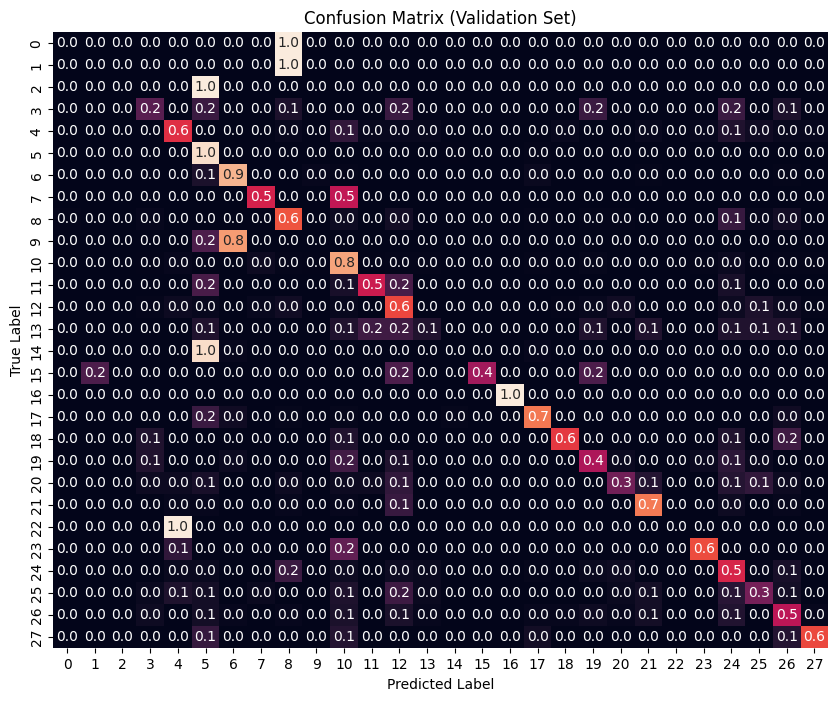

In [ ]:
plot_confusion_matrix(y_val, y_pred, classes=range(28), normalize=True, title="Confusion Matrix (Validation Set)")

In [29]:
print(classification_report(y_pred=y_pred, y_true=y_val))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.19      0.23      0.21        13
           4       0.63      0.56      0.59        48
           5       0.90      0.97      0.93       896
           6       0.88      0.86      0.87       111
           7       0.52      0.52      0.52        21
           8       0.69      0.64      0.66       103
           9       0.00      0.00      0.00         5
          10       0.78      0.82      0.80       216
          11       0.57      0.50      0.53        16
          12       0.55      0.62      0.58        91
          13       0.10      0.08      0.09        12
          14       0.00      0.00      0.00        53
          15       1.00      0.40      0.57         5
          16       1.00      1.00      1.00         1
          17       0.75    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [30]:
# test against test_2 (unexpected model performance)
X_test_2_labelled = X_test_2.copy()[:202] # only labelled
print(X_test_2_labelled.shape)
y_pred_2 = train_pipeline.predict(X_test_2_labelled.to_numpy())

(202, 300)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
print(classification_report(y_pred=y_pred_2, y_true=y_test_2))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.57      1.00      0.73         4
           5       0.42      0.89      0.57         9
           6       0.43      1.00      0.60         3
           7       1.00      0.36      0.53        14
           8       0.85      0.76      0.80        29
           9       0.00      0.00      0.00         3
          10       0.11      1.00      0.19         2
          11       1.00      0.78      0.88         9
          12       0.68      0.63      0.65        43
          13       0.33      1.00      0.50         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1
          17       1.00      0.80      0.89        10
          18       0.00      0.00      0.00         1
          19       0.33      0.25      0.29         4
          20       0.00    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

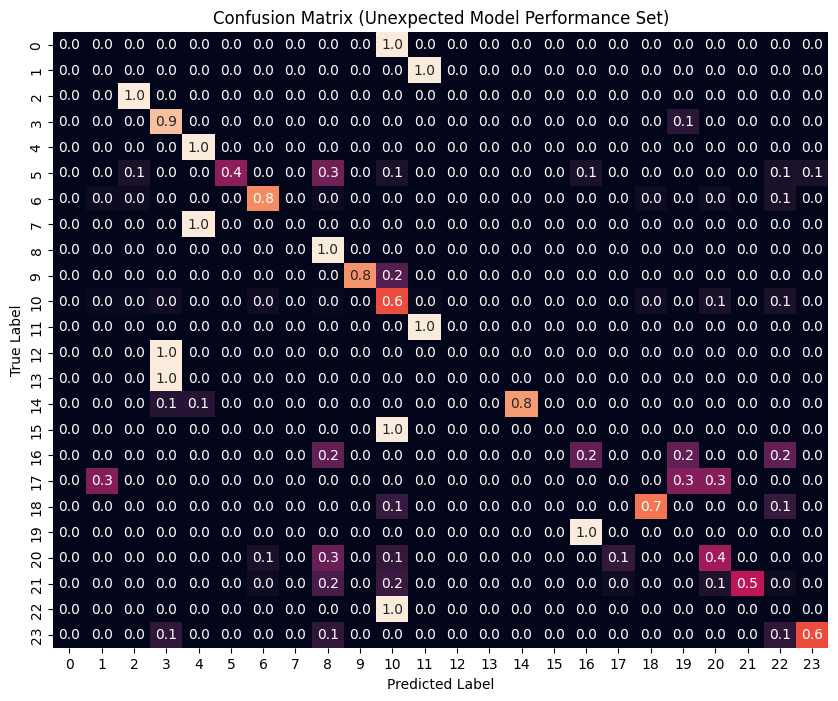

In [33]:
plot_confusion_matrix(y_test_2, y_pred_2, classes=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,23,24,25,26,27], normalize=True, title="Confusion Matrix (Unexpected Model Performance Set)")

# Overview
SMOTE helped improve original train/test performance. It used augmentation to generate an additional 115412 training samples for 4479 samples per class.
We achieve (on validation set):
- weighted, macro precision, recall and f1-score of 0.97.

However, on the unexpected test set:
- precision, recall, f1-score all tanked
- this indicates a struggle to generalise to new data.
- this could be due to overfitting (smote generated too much data?), concept drift, or the model memorising patterns only present in the test data
